# The Business-Case Introduction

## What is this business-case going to answer and where?

### The place:
Brooklyn, a USA Borough, in NEW York City.

### The problem:
A stakeholder has restaurant in Brooklyn, he wants to expand his business by opening a new branch in the same borough. Where would he be recommended to open? 
The stakeholder asked me to help him in finding the best place to open his new branch.

The stakeholder made an initial investigation and provide me with 5 places in Broklyn to state his business
![which place](https://alexmedia.co/brooklyn.jpg)
The current place appears in red, while the investigated places appear in blue

### The Dataset:
As a data analyst I got New York data from NYU spatial data repository and find that it has 5 boroughs:

* Manhattan with 40 neighbors
* Bronx with 52 neighbors
* Staten with Island 63 neighbors
* Brooklyn with 70 neighbors
* Queens with 81 neighbors


### The Methodology:
I planned my task as following by dividing  it into two main methods:
1. Get the top 100 venues that are in each distinct within a radius of 500 meters
2. Group venues by neighborhood and by taking the mean of the frequency of occurrence of each category
3. Retrieve each neighborhood along with the top 10 most common venues
4. Run k-means to cluster the neighborhood into 5 clusters.
5. make our decision based on generated clusters

## The Process:
We are going to work on "New York" state in USA
* First we will extract all Newyork neighbors usind data provided by NYU spatial data repository at https://geo.nyu.edu 
* Second, We will use Foursquare API  provided by https://developer.foursquare.com/ to retrieve all needed location, Borough, Categories, Rating, and Trending information
this is the main data we will use for cleaning, wrangling and put for further investigations

* Thirdly, We will use skilearn library from python to analysis our data using proper machine learning algorithms. here we will use K-means, an algorithm best suits our case analysis and investigations.

* Then we will use matplotlib library to visualize the investigated results on maps using Foluim library for python

* Finally, we will put it all together in a simple way, such that stackholders can make their decision easily based on our data analysis investigation for this business case.

# Data Insight and Prepration

In [4]:
# import pandas library to work with dataframe
import pandas as pd
import numpy as np
import matplotlib as mat

In [5]:
# @hidden_cell
CLIENT_ID = '2UABPTQXVSFUWXVMSQYXON4FACFMLWPELLQFVBYK3S0TLBNV' # your Foursquare ID
CLIENT_SECRET = 'AFKQI22J5NIJ1JSMPU0ZJ2TGHMPAIT04BAPUUD1MOAOIYVLE' # your Foursquare Secret
VERSION = '20180604'

In [89]:
#!conda install -c conda-forge geopy --yes 
!pip install geopy 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests # library to handle requests

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
!pip install folium
import folium # plotting library

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


In [7]:
# Function for creating map of any borough using latitude and longitude values
def print_map (my_data, zoom=11):
    my_map = folium.Map(location=[latitude, longitude], zoom_start=zoom)
    for lat, lng, label in zip(my_data['Latitude'], my_data['Longitude'], my_data['Neighborhood']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(my_map)
    return my_map

In [8]:
!wget -q -O 'newyork_data.json' https://geo.nyu.edu/download/file/nyu-2451-34572-geojson.json
print('Data downloaded!')

Data downloaded!


In [9]:
with open('newyork_data.json') as json_data:
    df_newyork = json.load(json_data)

In [10]:
df_newyork = df_newyork['features']

In [11]:
#let us have a look
df_newyork[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [12]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
newyork_data = pd.DataFrame(columns=column_names)

In [13]:
len(df_newyork)

306

In [14]:
# let us populate it
for data in df_newyork:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork_data = newyork_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [15]:
newyork_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [16]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(newyork_data['Borough'].unique()),
        newyork_data.shape[0]
    )
)

#how many neighborhood each borough has
df_groups = newyork_data.groupby (['Borough']).count()
df_groups

The dataframe has 5 boroughs and 306 neighborhoods.


,Neighborhood,Latitude,Longitude
Borough,,,
Bronx,52,52,52
Brooklyn,70,70,70
Manhattan,40,40,40
Queens,81,81,81
Staten Island,63,63,63


In [17]:
# Use geopy library to get the latitude and longitude values of New York City.
address = 'New York City, NY'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of New York City are 40.7308619, -73.9871558.


In [18]:
# create map of New York using latitude and longitude values
print_map (newyork_data, zoom=10)

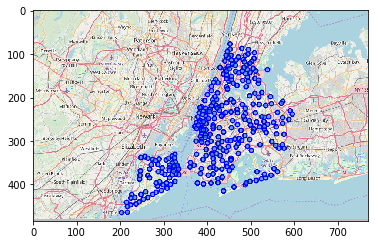

In [19]:
# a little tweak to show maps as images in github
plt.imshow(mpimg.imread('newyork.jpg'))

In [24]:
brooklyn_data = newyork_data[newyork_data['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [25]:
# create map of Manhattan using latitude and longitude values  
print_map (brooklyn_data, zoom=10)    


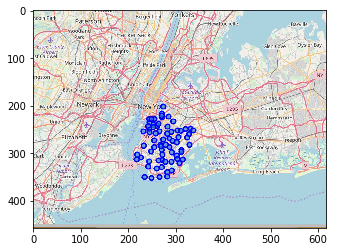

In [26]:
# a little tweak to show maps as images in github
plt.imshow(mpimg.imread('brooklyn.jpg'))
